In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:

# cross entropy summation function
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
#Q1. Execute the following statement. What is displayed? What does it mean?
!pwd
# we can get the directory where we are working on
# if run the code, we will get /content

/content


In [3]:
#Q2: Execute the following statement. What happens?  Examine the left column of your colab page to see what happens.
!git clone https://github.com/fastai/course-v3.git
# github주소에서 해당 유알엘에 있는 파일 복사해오기
# we can get the whole fine from github with url. Then new folder that is course-v3 appeared in our directory

Cloning into 'course-v3'...
remote: Enumerating objects: 5890, done.
remote: Total 5890 (delta 0), reused 0 (delta 0), pack-reused 5890
Receiving objects: 100% (5890/5890), 263.03 MiB | 35.07 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


In [4]:
#Q3. Execute the following statement. What are displayed by the execution of sys.path? What do it mean?
import sys
sys.path.append('/content/course-v3/nbs/dl2')
sys.path
## we can add a import path. sys.path shows us paths where we can upload python package to use by python system.
# python system find the name which we import in those area. So if we add specific path, we can import files from it


['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/course-v3/nbs/dl2']

In [5]:
#export
#Q4: "from exp.nb_01 import *" imports classes, functions, etc from module nb_01 in package exp.
# Q4a.   how do you know that exp is a package?
# Q4b.   How is the Python system able to get access to package exp? That is, how can it search for it?
from exp.nb_02 import *
import torch.nn.functional as F
## if there is __init__.py in a folder, python recognize it as package.
## python search the directories based on our sys.path. If it finds the directory, it searches the sub-directory and so forth until finding our import file or class

## Initial setup

### Data

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=1786)

In [6]:
from IPython.display import Image
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

def get_data():
    import os
    import torchvision.datasets as datasets
    root = '../data'
    if not os.path.exists(root):
        os.mkdir(root)

    train_set = datasets.MNIST(root=root, train=True, download=True)
    test_set = datasets.MNIST(root=root, train=False, download=True) #load validation set
    x_train, x_valid = train_set.data.split([50000, 10000])
    y_train, y_valid = train_set.targets.split([50000, 10000])
    return (x_train.view(50000, -1) / 256.0), y_train.float(), (x_valid.view(10000, -1))/ 256.0, y_valid.float()



In [7]:
mpl.rcParams['image.cmap'] = 'gray'

In [8]:
#Q5: when you execute the following statement, where is the downloaded data stored? Examine the left column of your colab page.
x_train,y_train,x_valid,y_valid = get_data()
##  if we download, they are stored in the root path which we specified "../data"
## .. means parent-directory. If we are in content then,finding from !pwd , python go up to parent directory which is '/' then make the data directory and finally save the datas in that directory


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
y_train.shape

torch.Size([50000])

In [10]:
#Q6a: Execute the following statement. What does the number displayed mean?
len(x_train)
## 데이터샘플 개수
# we can get the number of data sampels which is first shape of x_train

50000

In [11]:
#Q6b: Execute the following statement. What does the numbers displayed mean?
y_train[0]
## 이미지 라벨
# we can get the first image's label which is the answer for the image.
# To know why it is 5, mnists dataset's answers consist of 0~9, digit number. And the first image represents 5.
# thats why it is 5.

tensor(5.)

In [12]:
#Q7: Display the values of n,m, c, and nh. What are they? For what are they used in the following code? 
n,m = x_train.shape
c = y_train.max()+1
nh = 50
# n피쳐데이터, m샘플데이터 - , c는 마지막에 사용
# if we have neural net consisting of layer1,layer2,
# n is the number of feature of each sample which is used for layer1 weight matrix multiplication
# m is the number of samples, and it's dimension,50000, will kept throughout the whole neural net layers
# nh is the number of hidden nodes for each sample, especially for layer 1's.
# c is the kinds of labels,10, which we want to predict. It is the output number of layer2's node for each sample

In [13]:
#Q8: The following defines Model class, which will be used to create a neural net.
#Q8a: What is nn.Module?, What is nn.Linear? What is nn.ReLU? 
#Q8b. What is the difference between  nn.Linear itself and nn.Linear(n_in,nh) ? 

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x
#  
# nn.linear is linear layer which makes fully conntected layer applying linear transformation from input to output
# nn.Relu is the activation layer using Relu which works as max(0,x)
# Base class for all neural network modules. Your models should also subclass this class. Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:
# nn.Module is the basic neural net module like a basket. After adding layers to that module, we can construct the neural net
# nn.Module encapsulate the parmeters, helping to use gpus,exporting,loading etc like a helper for making model class
# We often inherit this module when we make model class
# nn.Linear is class itself while nn.Linear(n_in,nh) means initializing the class to instance. It executes __init__ with parameters.

In [14]:
#Q9a. When Model(m,nh, 10) is executed, which method in Model class is executed?
model = Model(m, nh, 10)
# __init__
# If we initialize the class, __init__ function will be executed.
# In general, they declare the variables with parameters.

In [15]:
#Q10a. Is model a function or an object? If it is an object, how is it used as if it is a function?
# When model(x_train) is executed, which method in Model is executed. What does this method create? 
pred = model(x_train)
# After we initialize the class, we can also execute with parameters using __call__ function
# In nerual net model, we often predict the result with train data input using __call__ function

In [16]:
#Q11: Execute the following statement. What does the displayed numbers mean?
pred[0]
# pred[0] means the degree of being 10 labels each for first data sample. In general, we select the prediction label with biggest number
# Because we have 10 labels, there are also 10 numbers.
# for example, pred[0][0] means how much likely to be the label 0.

tensor([-0.0412, -0.0449, -0.2077,  0.0361,  0.2382,  0.2453, -0.1610, -0.1783,
         0.0115,  0.0708], grad_fn=<SelectBackward>)

In [18]:
#Q12. Execute the following statement. Is the resulting value near to 1? If not, what does it imply?
pred[0].sum()
# Of course not, it is just likely weight for each label not the proability.
# So if we want to apply statstic proability concept for predicting label, we need to convert those number to probability

tensor(-0.0313, grad_fn=<SumBackward0>)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [19]:
def softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True)))

In [20]:
sm_pred = softmax(pred)


In [21]:
#Q13. Execute the following statement. What does the displayed numbers mean?
sm_pred[0]
# each number means probability of each label being correct.
# for exmaple, if sm_pred[0][0] is 0.3, the proability of the image being 0 is 0.3
# Also their number arranges from 0 ~ 1 which is Probabilistic interval

tensor([0.0952, 0.0948, 0.0806, 0.1028, 0.1258, 0.1267, 0.0844, 0.0830, 0.1003,
        0.1064], grad_fn=<SelectBackward>)

In [22]:
#Q14. Execute the following statement. What does the displayed numbers mean?
sm_pred[0].sum()
# this should be 1 if it is subordinate with probability.
# this means each number gives us the information about how much probable each label would be the answer.

tensor(1.0000, grad_fn=<SumBackward0>)

In [23]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [24]:
log_sm_pred = log_softmax(pred)

In [25]:
log_sm_pred[0]

tensor([-2.3522, -2.3559, -2.5187, -2.2749, -2.0728, -2.0658, -2.4721, -2.4894,
        -2.2996, -2.2402], grad_fn=<SelectBackward>)

In [26]:
log_sm_pred[0].sum()

tensor(-23.1415, grad_fn=<SumBackward0>)



## Q15. Read the following paragraph to understand what the cross entroy loss functioni is. 

The difference between probabilities interpretation: https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation

The cross entropy formula takes in two distributions,  $p(x^{(s)})$, the true distribution (defined by the label data), and $\hat{p}(x^{(s)})$, the estimated distribution (predicted by the neural net), defined over the discrete variable x and is given by

$H(p,\hat{p})=−\sum_{s \in B} p(x^{(s)}) \cdot log(\hat{p}(x^{(s)}))$


In general, $ p(x^{(s)}) = [ p_{1} (x^{(s)}), ..., p_{n}(x^{(s)})]$ is a probability distribution over a set of categories. 
But since our $ p(x^{(s)})$ are 1-hot encoded, that is, in the form of  $ p(x^{(s)}) =[0,0,..,0,1,0..]$, where the probability of only one category is one and those of the other categories are all zero, this can be rewritten as

 $-\sum_{s \in B} [ 0*\log(\hat{p}_{1} (x^{(s)}))
 + 1*\log(\hat{p}_{i} (x^{(s)}) ) +..+0*\log(\hat{p}_{n} (x^{(s)}) ) ] \\
  = -\sum_{s \in B} \log(\hat{p}_{i(s)} ) (x^{(s)}) ) 
  \tag{crossEntroyEq}$ 

#  In this notebook, the softmax function plays the role of the probability distribution $\hat{p}_{1} (x^{(s)})$.

  Here $i(s)$ is the index of the one-hot  probability distribution $p(x^{(s)})$ where the probability is one. 
 
 

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [27]:
#Q15a. Execute the following statement. What do the displayed numbers mean? 
y_train[:3]
# This number means that for 3 sample datas the images represents 5,0,4 each
# it does not coverted into one-hot vector yet. For eaxample, [0,0,0,0,0,1,0,0,0,0] for 5
# meaning probability of being numbers 0 through 9 except 5 is 0%, and prability of being 5 is 100%

tensor([5., 0., 4.])

In [28]:
#Q15b.  Execute the following statement. What do the displayed numbers mean? 
log_sm_pred[ [0,1,2]]
# They represent the log_softmax numbers of being the answer 0 to 9 each for 3 samples.
# Becuase there are 10 kinds of answers, there are 10 elements for each vector.
# It is calculated by softmax and log.
# First we calcuate probability of each label using softmax, then we apply the log 
# why we use log is to get benefit from caculation in proability and
# it makes more penalty on big loss than softmax which makes the model training efficient.


tensor([[-2.3522, -2.3559, -2.5187, -2.2749, -2.0728, -2.0658, -2.4721, -2.4894,
         -2.2996, -2.2402],
        [-2.2425, -2.3675, -2.5629, -2.2829, -2.0346, -2.0615, -2.4655, -2.4647,
         -2.3155, -2.3611],
        [-2.2945, -2.3563, -2.4126, -2.2710, -2.1739, -2.1068, -2.3705, -2.4384,
         -2.3605, -2.2911]], grad_fn=<IndexBackward>)

In [29]:
#Q15c.  Execute the following statement. What do the displayed numbers mean? Explain compare the result of Q15b and the result of this statement.
log_sm_pred[[0,1,2], [5,0,4]]
# The numbers means first sample data is log_softmax values likely to be 5 and second sample data is likely to be 0 and so forth each.
# We know the answer for each sample, so ideal number for each is 0, because log(1) = 0
# If the number is not closest to 0, we need to train more until certain point
# If we calcuate the loss with 15b, lots of computing resources are wasted. Because all probability except the answer becomes 0 in one-hot label data, we don't
# need the other numbers. For example, if we calcuate the loss of first sample, we need only log_sm_red[0][5], where answer is 5, to mulitply when we uses cross-entropy loss.
# not the whole vector output of first sample which is log_sm_red[0]
# So to be efficient loss calculation with cross_entropy, 15c is desirable.

tensor([-2.0658, -2.2425, -2.1739], grad_fn=<IndexBackward>)

In [30]:
y_train.shape[0]

50000

In [31]:
y_train

tensor([5., 0., 4.,  ..., 8., 4., 8.])

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2081)

In [32]:
log_sm_pred[0]

tensor([-2.3522, -2.3559, -2.5187, -2.2749, -2.0728, -2.0658, -2.4721, -2.4894,
        -2.2996, -2.2402], grad_fn=<SelectBackward>)

In [33]:
range(y_train.long()[0:10].shape[0])

range(0, 10)

In [34]:
log_sm_pred[ range(y_train.long()[0:10].shape[0]), y_train.long()[0:10] ]

tensor([-2.0658, -2.2425, -2.1739, -2.3419, -2.3175, -2.4383, -2.4129, -2.2841,
        -2.3639, -2.2075], grad_fn=<IndexBackward>)

In [35]:
def nll(input, target):
   
   return -input[range(target.shape[0]), target].mean()

In [36]:
y_train.long().shape[0]

50000

In [37]:
x_train.shape

torch.Size([50000, 784])

In [38]:
#Q16. Read nill function and explain how this function computes the result. You need to refer to {CrossEntropyLoss}.
loss = nll(log_sm_pred, y_train.long())
# first we infer the log proability of each label for each image using log_softmax.
# then using crossentropy loss, we calculate the loss of each sample and get the average of total samples' loss
# if we calculate crossentropy loss, we only use the logsoftmax value on answer index from prediction of model to save resources.
# since,except the answer index value of answer-one hot encoding, there are all zero which are used to mulitply with output of model on each value

In [39]:
y_train

tensor([5., 0., 4.,  ..., 8., 4., 8.])

In [40]:
y_train.long()

tensor([5, 0, 4,  ..., 8, 4, 8])

In [41]:
loss

tensor(2.3193, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [42]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [43]:
test_near(nll(log_softmax(pred), y_train.long()), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [52]:
def logsumexp(x):
    print(x[0])
    print(x[0].max(-1))
    m = x.max(-1)[0]
    print(m[0])
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [53]:
test_near(logsumexp(pred), pred.logsumexp(-1))

tensor([-0.0412, -0.0449, -0.2077,  0.0361,  0.2382,  0.2453, -0.1610, -0.1783,
         0.0115,  0.0708], grad_fn=<SelectBackward>)
torch.return_types.max(
values=tensor(0.2453, grad_fn=<MaxBackward0>),
indices=tensor(5))
tensor(0.2453, grad_fn=<SelectBackward>)


So we can use it for our `log_softmax` function.

In [54]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [55]:
test_near(nll(log_softmax(pred), y_train.long()), loss)

Then use PyTorch's implementation.

In [57]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train.long()), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [58]:
test_near(F.cross_entropy(pred, y_train.long()), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2542)

In [59]:
loss_func = F.cross_entropy # This criterion combines log_softmax and nll_loss in a single function.

In [64]:
#export
def accuracy(out, yb): 
    print(out[0])
    print(torch.argmax(out, dim=1))
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [66]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0412, -0.0449, -0.2077,  0.0361,  0.2382,  0.2453, -0.1610, -0.1783,
          0.0115,  0.0708], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [67]:
yb = y_train[0:bs]
loss_func(preds, yb.long())

tensor(2.3114, grad_fn=<NllLossBackward>)

In [68]:
accuracy(preds, yb)

tensor([-0.0412, -0.0449, -0.2077,  0.0361,  0.2382,  0.2453, -0.1610, -0.1783,
         0.0115,  0.0708], grad_fn=<SelectBackward>)
tensor([5, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 3, 4, 5, 4, 5, 4, 4, 5, 5, 5, 5, 4, 4,
        9, 4, 5, 4, 4, 5, 4, 5, 5, 5, 4, 5, 4, 5, 4, 5, 4, 4, 3, 5, 4, 4, 4, 4,
        5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 4, 5, 5, 5, 4])


tensor(0.0312)

In [69]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

# The mechanism for training the network: (1) computing the graidents of Loss with respect to tensors at each layer, (2) backpropgation: applying the chain rule to compute the gradient vector of the parameters, (3) updating the parameters.

https://github.com/pytorch/pytorch/blob/35bd2b3c8b64d594d85fc740e94c30aa67892a34/torch/tensor.py

https://github.com/pytorch/pytorch/blob/35bd2b3c8b64d594d85fc740e94c30aa67892a34/torch/tensor.py

https://stackoverflow.com/questions/57248777/backward-function-in-pytorch
: Pytorch does not support this non-scalar function derivatives. Instead, pytorch assumes out is only an intermediate tensor and somewhere "upstream" there is a scalar loss function, that through chain rule provides d loss/ d out[i,j]. This "upstream" gradient is of size 2-by-3 and this is actually the argument you provide backward in this case: out.backward(g) where g_ij = d loss/ d out_ij.

The gradients are then calculated by chain rule d loss / d a[i,j] = (d loss/d out[i,j]) * (d out[i,j] / d a[i,j]); In fact,  So it's not just (d loss/d out[i,j]) * (d out[i,j] / d a[i,j]), but in fact sum_{k,l} (d loss/d out[k,l]) * (d out[k,l] / d a[i,j]).

# The "gradient accumulation"

https://discuss.pytorch.org/t/why-do-we-need-to-set-the-gradients-manually-to-zero-in-pytorch/4903/9

In the following example, y.backward() is called 5 times, so the final value of x.grad will be 5*cos(0)=5.

import torch
from torch.autograd import Variable

x = Variable(torch.Tensor([[0]]), requires_grad=True)

for t in range(5):
    y = x.sin() 
    y.backward()
    
print(x.grad) # shows 5
Calling x.grad.data.zero_() before y.backward() can make sure x.grad is exactly the same as current y’(x), not a sum of y’(x) in all previous iterations.

x = Variable(torch.Tensor([[0]]), requires_grad=True) 

for t in range(5):
    if x.grad is not None:
        x.grad.data.zero_()
    y = x.sin() 
    y.backward()

print(x.grad) # shows 1
I also got confused by this “zeroing gradient” when first learning pytorch. The doc of torch.autograd.backward does mention that

This function accumulates gradients in the leaves - you might need to zero them before calling it.

But this is quite hard to find and pretty confusing for (say) tensorflow users.

Official tutorials like 60 Minute Blitz 45 or PyTorch with Examples 69 both say nothing about why one needs to call grad.data.zero_() during training. I think it would be useful to explain this a little more in beginner-level tutorials. RNN is a good example for why accumulating gradient (instead of refreshing) is useful, but I guess new users wouldn’t even know that backward() is accumulating gradient


# A more rigorous reference to autograd:

https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/

torch.no_grad():

When we are computing gradients, we need to cache input values, and intermediate features as they maybe required to compute the gradient later.

The gradient of  
b
=
w
1
∗
a
 w.r.t it's inputs 
w
1
 and 
a
 is 
a
 and 
w
1
 respectively. We need to store these values for gradient computation during the backward pass. This affects the memory footprint of the network.

While, we are performing inference, we don't compute gradients, and thus, don't need to store these values. Infact, no graph needs to be create during inference as it will lead to useless consumption of memory.

PyTorch offers a context manager, called torch.no_grad for this purpose.


with torch.no_grad:

	inference code goes here 

No graph is defined for operations executed under this context manager.




In [70]:
from torch.autograd import Variable
import torch
x = Variable(torch.Tensor([[0]]), requires_grad=True)

for t in range(5): 
    y = x.sin()
    y.backward()

    print(x.grad)

tensor([[1.]])
tensor([[2.]])
tensor([[3.]])
tensor([[4.]])
tensor([[5.]])


In [71]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
cost_function = F.cross_entropy

In [72]:
lr = 0.5   # learning rate
epochs = 2 # how many epochs to train for

In [76]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1): # for each batch in the current epoch
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        ybHat = model(xb)
        h = ybHat.register_hook( lambda grad: print (grad) )

        loss = loss_func( ybHat, yb.long())

        # loss.backward() computes the gradient of loss w.r.t. graph LEAVES.
        #  This function accumulates gradients in the leaves - you might need to zero
        # ``.grad`` attributes or set them to ``None`` before calling it.
        #  (This makes it easier for rnn, because each module will be back propogated through several times.)
       
       # Attribute grad of tensor ybHat (ybHat.grad = dloss/dybHat) is ``None`` by default and becomes a Tensor the first time a call to
        #func `backward` computes gradients for ybHat.
        #The attribute will then contain the gradients computed and future calls to
        #:func:`backward` will accumulate (add) gradients into it.

        #Since the backward() function accumulates gradients, and you don’t want to mix up gradients between minibatches, 
        # you have to zero them out at the start of a new minibatch.
       


        ybHat.grad
        loss.backward() # When you call loss.backward(), all it does is compute gradient of loss 
                        # w.r.t all the parameters in loss that have requires_grad = True and store them in parameter.grad attribute for every parameter

        ybHat.grad                
        #optimizer.step() updates all the parameters based on parameter.grad 
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr

                    #we don't care about gradients from the previous batch. Not zeroing grads would lead to gradient accumulation across batches
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

tensor([[ 2.8639e-11,  5.0197e-12,  7.6480e-13,  4.6426e-06,  7.8007e-18,
         -4.6715e-06,  2.3612e-13,  1.5880e-13,  1.7212e-14,  3.0065e-08],
        [-4.8429e-08,  1.1404e-12,  3.4232e-08,  5.8735e-12,  8.2275e-11,
          8.4376e-13,  2.9224e-09,  6.7393e-09,  2.1853e-11,  3.6548e-09],
        [ 5.8160e-08,  1.9815e-07,  3.4483e-05,  1.7391e-06, -5.6699e-05,
          6.6204e-08,  8.8445e-06,  7.2992e-06,  9.1404e-07,  3.0959e-06],
        [ 1.1090e-09, -3.0613e-06,  3.7656e-07,  6.4584e-09,  1.1344e-08,
          7.8872e-09,  7.3895e-09,  2.1007e-06,  5.5162e-07,  7.5181e-11],
        [ 8.1127e-09,  4.7647e-09,  6.2809e-09,  5.9257e-08,  1.0071e-04,
          2.7890e-07,  6.1293e-09,  1.2049e-05,  1.8679e-05, -1.3180e-04],
        [ 9.3747e-07,  1.7583e-07, -5.5453e-05,  2.1503e-06,  2.0898e-06,
          1.6474e-06,  1.4952e-05,  6.5125e-07,  2.9420e-05,  3.4269e-06],
        [ 1.4793e-11, -3.7039e-06,  2.7603e-08,  1.0904e-06,  4.3990e-07,
          2.7844e-09,  9.1467e-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


In [77]:
loss_func(model(xb), yb.long()), accuracy(model(xb), yb)

(tensor(0.0069, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2818)

In [78]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [79]:
model = Model(m, nh, 10)

In [80]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [81]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [82]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [83]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb.long())

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [ ]:
fit()
loss_func(model(xb), yb.long()), accuracy(model(xb), yb)

(tensor(0.2048, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [84]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [85]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [86]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=2997)

In [87]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [88]:
# add_module 상속
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [89]:
model = Model(layers)

In [90]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3173)

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = SequentialModel(layers)

In [ ]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()
loss_func(model(xb), yb.long()), accuracy(model(xb), yb)

(tensor(0.0107, grad_fn=<NllLossBackward>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3199)

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
fit()
loss_func(model(xb), yb.long()), accuracy(model(xb), yb)

(tensor(0.1236, grad_fn=<NllLossBackward>), tensor(0.9375))

In [ ]:
from torch import nn
nn.Sequential??

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3278)

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb)
loss,acc

(tensor(0.1114, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [ ]:
#export
from torch import optim

In [ ]:

optim.SGD.step??

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model,opt = get_model()
loss_func(model(xb), yb.long())

tensor(2.3170, grad_fn=<NllLossBackward>)

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step() # model parameter 불러와서 gradient update
        opt.zero_grad() # 

In [ ]:
loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb)
loss,acc

(tensor(0.2243, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3442)

In [ ]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3578)

In [ ]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [ ]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [ ]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5., 0., 4., 1., 9.]))

In [ ]:
model,opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3409, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3674)

In [ ]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3.)

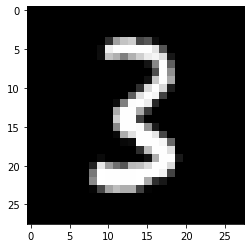

In [ ]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model,opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb.long())
            loss.backward()
            opt.step()
            opt.zero_grad()

In [ ]:
fit()

In [ ]:
loss,acc = loss_func(model(xb), yb.long()), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0518, grad_fn=<NllLossBackward>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3942)

In [ ]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [ ]:
small_ds = Dataset(*train_ds[:10])

In [ ]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [ ]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([9, 6, 7]), tensor([3, 2, 0]), tensor([5, 4, 8]), tensor([1])]

In [ ]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [ ]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3.)

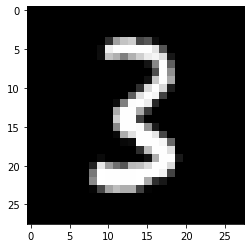

In [ ]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(4.)

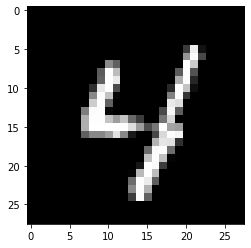

In [ ]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9.)

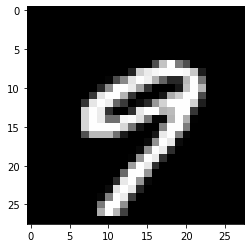

In [ ]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

RuntimeError: ignored

### PyTorch DataLoader

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4171)

In [ ]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

RuntimeError: ignored

PyTorch's defaults work fine for most things however:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [ ]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

RuntimeError: ignored

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=4260)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb.long())
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb.long())
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [ ]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2109) tensor(0.9345)
1 tensor(0.1198) tensor(0.9660)
2 tensor(0.1526) tensor(0.9538)
3 tensor(0.1194) tensor(0.9668)
4 tensor(0.1065) tensor(0.9705)


In [ ]:
assert acc>0.9

## Export

In [ ]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to nb_03.py
